In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls
%cd drive/MyDrive/9444/group_ass/VOC2012

drive  sample_data
/content/drive/MyDrive/9444/group_ass/VOC2012


In [56]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 44.3 MB/s eta 0:00:00


In [68]:
import os
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from collections import defaultdict
import json
import pandas as pd


## 1. Data Preprocessing
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
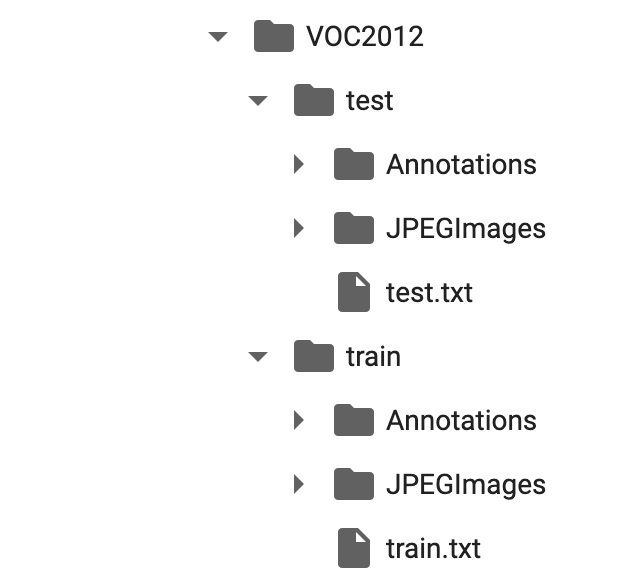

In [47]:
os.chdir('/content/drive/MyDrive/9444/group_ass')

In [48]:
# set the new dataset path
root_path = './new_dumpsite_data'
train_file_Annotations = os.path.join(root_path, "train", "Annotations")
test_file_Annotations = os.path.join(root_path, "test", "Annotations")

# Create directories if they do not exist
os.makedirs(train_file_Annotations, exist_ok=True)
os.makedirs(test_file_Annotations, exist_ok=True)

print(os.getcwd())
print(f"Train Annotations directory: {train_file_Annotations}")
print(f"Test Annotations directory: {test_file_Annotations}")

/content/drive/MyDrive/9444/group_ass
Train Annotations directory: ./new_dumpsite_data/train/Annotations
Test Annotations directory: ./new_dumpsite_data/test/Annotations


In [66]:
# convert annotation files to find How many labels are there
def convert_annotation_find_labels(path):
  labels = []
  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      for ele in root.findall('object'):
          label = ele.find('name').text
          labels.append(label)
  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations')

VOC2012/train/Annotations {'domestic garbage', 'mining waste', 'agriculture forestry', 'industry waste', 'disposed garbage', 'construction waste'}
VOC2012/test/Annotations {'construction waste', 'agriculture forestry', 'domestic garbage', 'disposed garbage'}


In [63]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [67]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
print('train_object_labels', train_object_labels)

train_object_labels [1, 1, 1, 3, 1, 6, 6, 6, 6, 1, 1, 1, 1, 6, 1, 6, 6, 1, 6, 1, 6, 1, 6, 1, 1, 1, 1, 3, 1, 1, 1, 1, 6, 1, 6, 6, 6, 6, 6, 1, 3, 1, 3, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 1, 1, 1, 1, 6, 6, 1, 3, 1, 1, 1, 1, 6, 6, 6, 1, 1, 6, 6, 1, 6, 3, 1, 1, 1, 6, 3, 1, 6, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6

In [71]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df

,train_labels_distribution
domestic garbage,2301
agriculture forestry,247
construction waste,581
disposed garbage,9
mining waste,1
industry waste,1
